## `Building makemore Part 5: Building a WaveNet`

* `pytorch` document is not very good. It will lie to you, imcomplete. But it is what it is.
* There are lot of gymnastics on multi-dimension array.
* I very often Prototype these layers in implementation in Jupyter notebooks and make sure all the shapes workout. Once I am satisfied with the functionality in notebook then copy-paste into vscode and kick off experiment from repo/vscode.

In [124]:
## import modules
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import torch.nn.functional as F
#from .autonotebook import tqdm as notebook_tqdm

In [125]:
## Read the file
words = open('../makemore/names.txt', 'r').read().splitlines()
len(words)

32033

In [126]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(f'vocab_size = {vocab_size}')

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size = 27


In [127]:
block_size = 8 ## This means looking previous 8 words

'''
Building dataset
'''
def build_dataset(words):    
    X, Y = [], []

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)            
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [128]:
'''
Splitting dataset into train, validation and test set
'''
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [129]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])                    

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [130]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []  
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)            
        self.out = x
        return self.out
    
    def parameters(self):
        return [] 

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [131]:
torch.manual_seed(42); 

In [132]:
vocab_size, block_size

(27, 8)

In [133]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # last layer: make less confident
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22397


In [134]:
## scratchpace
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
print(Xb.shape)
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])
torch.Size([4, 8])


tensor([[ 0,  0,  0, 13,  9, 12,  9,  1],
        [ 0,  0,  0,  1, 22,  1, 12, 25],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0, 11,  8, 25, 14]])

In [135]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [136]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [137]:
model.layers[1].out.shape

torch.Size([4, 4, 20])

In [138]:
model.layers[2].out.shape

torch.Size([4, 4, 68])

In [139]:
(torch.randn(4,80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [140]:
'''
We want to break this 80 into 4 groups like (1,2) , (3,4) , (5,6) , (7,8)
'''
(torch.randn(4, 4, 20) @torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [141]:
## Lst[Initial : End : IndexJump]
list(range(10))[1::2] ## IndexJump of 2

[1, 3, 5, 7, 9]

In [142]:
e = torch.randn(4, 8, 10)
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim = 2)
explicit.shape

torch.Size([4, 4, 20])

In [143]:
(e.view(4, 4, 20) == explicit).all() ## Hence pytorch.view does things for you.

tensor(True)

In [144]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass

    for layer in model.layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())    

    #break

      0/ 200000: 3.2970
  10000/ 200000: 2.0274
  20000/ 200000: 2.5108
  30000/ 200000: 1.9575
  40000/ 200000: 2.1730
  50000/ 200000: 1.9833
  60000/ 200000: 1.6354
  70000/ 200000: 1.9444
  80000/ 200000: 2.4345
  90000/ 200000: 1.9624
 100000/ 200000: 2.0467
 110000/ 200000: 1.8868
 120000/ 200000: 2.2666
 130000/ 200000: 1.4401
 140000/ 200000: 1.8623
 150000/ 200000: 1.6171
 160000/ 200000: 2.0226
 170000/ 200000: 1.7258
 180000/ 200000: 2.0426
 190000/ 200000: 2.2032


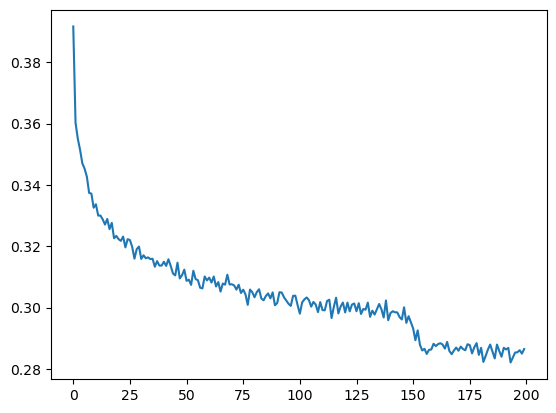

In [145]:
'''
Loss Plot
'''
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1));

In [146]:
'''
Put layers into eval mode needed for batchnorm especially
'''
for layer in model.layers:
    layer.training = False

In [147]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())    

In [149]:
split_loss('train')
split_loss('val')

train 1.9108837842941284
val 2.0214338302612305


In [150]:
'''
How to take sample from the model
'''
for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:        
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item() ## to get the next index
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))     

mesyk.
alliera.
doltanton.
mohan.
ghili.
hajad.
keyana.
avyaan.
tay.
yarely.
sand.
shredan.
eardhadi.
khad.
emere.
naiyeah.
ayidori.
rhyren.
yardon.
haxrik.
